In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import cv2


In [2]:
class_name=os.listdir('Drug Vision/Data Combined')
class_name

['Alaxan',
 'Bactidol',
 'Bioflu',
 'Biogesic',
 'DayZinc',
 'Decolgen',
 'Fish Oil',
 'Kremil S',
 'Medicol',
 'Neozep']

In [3]:
class_distribution = [len(os.listdir('Drug Vision/Data Combined/'+i)) for i in class_name]
class_distribution

[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]

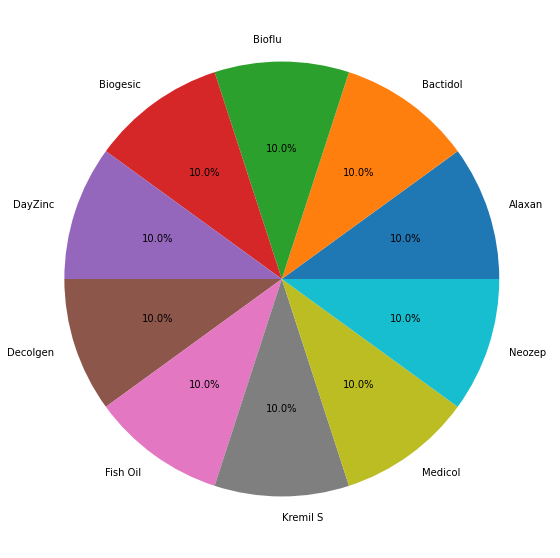

In [4]:
plt.figure(figsize=(10,10),facecolor='white')
plt.pie(class_distribution, labels=class_name, autopct='%1.1f%%')
plt.show()

In [5]:
gen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,rotation_range=20,brightness_range=[0.5,0.9],horizontal_flip=True,zoom_range=0.2,validation_split=0.2)
train_data=gen.flow_from_directory('Drug Vision/Data Combined',target_size=(224,224),batch_size=32,subset='training',class_mode='categorical')
val_data=gen.flow_from_directory('Drug Vision/Data Combined',target_size=(224,224),batch_size=32,subset='validation',class_mode='categorical')


Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


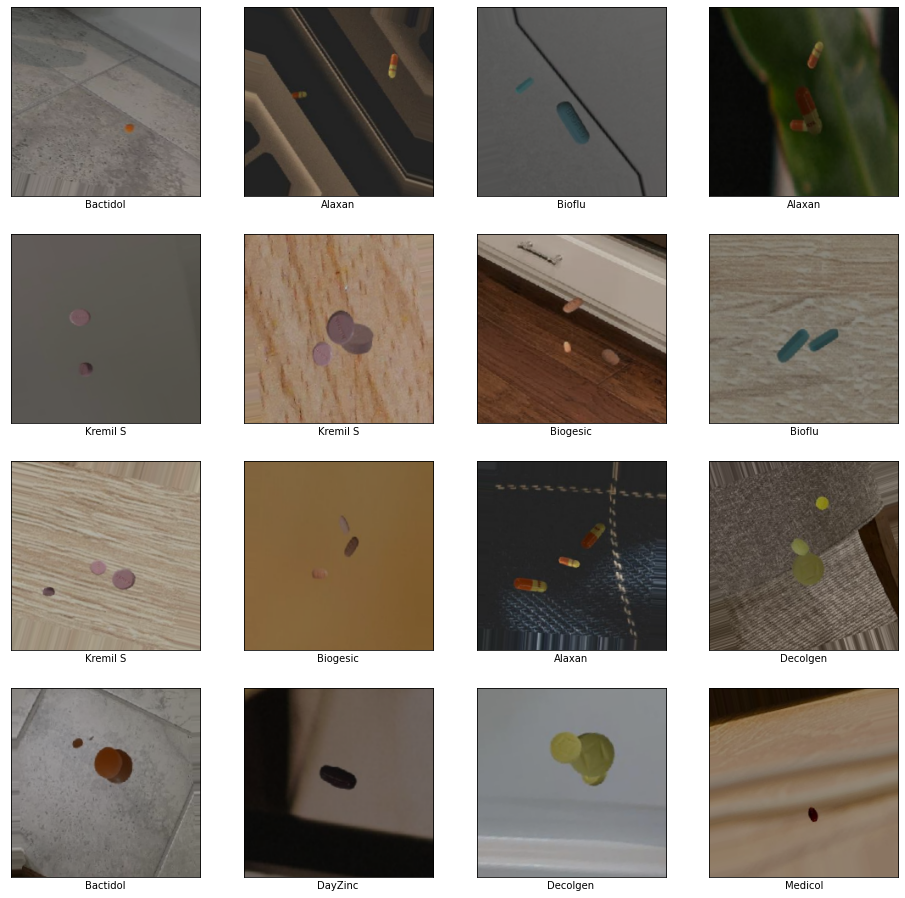

In [6]:
plt.figure(figsize=(16,16),facecolor='white')
for i in range(16):
      plt.subplot(4,4,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(train_data[0][0][i])
      plt.xlabel(class_name[np.argmax(train_data[0][1][i])])
plt.show()

In [40]:
model=Sequential(
    [
        Conv2D(32,activation='relu',input_shape=(224,224,3),kernel_size=5,padding='valid',strides=2),
        BatchNormalization(),
        Conv2D(64,kernel_size=3,strides=1,padding="same",activation='relu'),
        Conv2D(64,kernel_size=3,strides=1,padding="same",activation='relu'),
        MaxPooling2D(),
        Conv2D(128,kernel_size=3,strides=1,padding="same",activation='relu'),
        Conv2D(128,kernel_size=3,strides=1,padding="same",activation='relu'),
        GlobalAveragePooling2D(),
        Dense(164,activation='relu'),
        Dense(64,activation='relu'),
        Dense(len(class_name),activation='softmax'),
    ]
)

In [41]:

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
callbacks = [
      tf.keras.callbacks.EarlyStopping(patience=15,monitor='val_accuracy',mode='max',restore_best_weights=True),
      ModelCheckpoint('Custom-01.h5',save_best_only=True,monitor='val_accuracy',mode='max')
   ]
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 110, 110, 32)      2432      
                                                                 
 batch_normalization_3 (Batc  (None, 110, 110, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_16 (Conv2D)          (None, 110, 110, 64)      18496     
                                                                 
 conv2d_17 (Conv2D)          (None, 110, 110, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 55, 55, 128)      

Epoch 1/150
250/250 [==============================] - 142s 563ms/step - loss: 2.3042 - accuracy: 0.1032 - val_loss: 2.3026 - val_accuracy: 0.0990
Epoch 2/150
250/250 [==============================] - 137s 548ms/step - loss: 2.3036 - accuracy: 0.0984 - val_loss: 2.3024 - val_accuracy: 0.1015
Epoch 3/150
250/250 [==============================] - 139s 556ms/step - loss: 2.3044 - accuracy: 0.1025 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/150
250/250 [==============================] - 139s 557ms/step - loss: 2.2981 - accuracy: 0.1124 - val_loss: 2.2713 - val_accuracy: 0.1430
Epoch 5/150
250/250 [==============================] - 141s 562ms/step - loss: 1.9560 - accuracy: 0.2326 - val_loss: 1.8503 - val_accuracy: 0.2515
Epoch 6/150
250/250 [==============================] - 140s 560ms/step - loss: 1.7211 - accuracy: 0.2862 - val_loss: 1.6331 - val_accuracy: 0.3210
Epoch 7/150
250/250 [==============================] - 139s 557ms/step - loss: 1.6216 - accuracy: 0.3326 - val_loss: 1

<AxesSubplot:>

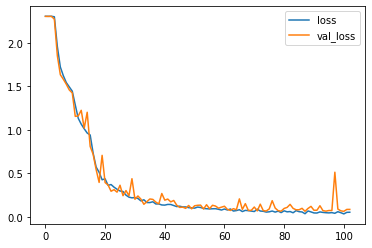

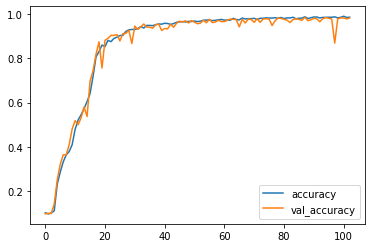

In [42]:
history=model.fit(train_data,epochs=150,validation_data=val_data,callbacks=callbacks)
history=pd.DataFrame(history.history)
history.loc[:,['loss','val_loss']].plot()
history.loc[:,['accuracy','val_accuracy']].plot()

In [43]:
model.evaluate(val_data)

63/63 [==============================] - 28s 449ms/step - loss: 0.0699 - accuracy: 0.9810


[0.06986313313245773, 0.9810000061988831]

In [45]:
#save model
model.save('Custom-02.h5')

In [7]:
#load model
model2=tf.keras.models.load_model('Custom-02.h5')

In [8]:
from keras.utils import load_img, img_to_array
def predict(img_rel_path):
    img = load_img(img_rel_path, target_size=(224, 224))
    img = img_to_array(img, dtype=np.uint8)
    img = np.array(img)/255.0
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()
    p = model2.predict(img[np.newaxis, ...])
    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = class_name[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")
    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")
    for i,j in enumerate (p[0],0):
        print(class_name[i].upper(),':',round(j*100,2),'%')
        classes.append(class_name[i])
        prob.append(round(j*100,2))      
    def plot_bar_x():
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()
    plot_bar_x()

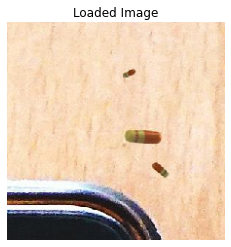

1/1 [==============================] - 11s 11s/step


Maximum Probability:  0.9999993
Classified: Alaxan 



-------------------Individual Probability--------------------------------

ALAXAN : 100.0 %
BACTIDOL : 0.0 %
BIOFLU : 0.0 %
BIOGESIC : 0.0 %
DAYZINC : 0.0 %
DECOLGEN : 0.0 %
FISH OIL : 0.0 %
KREMIL S : 0.0 %
MEDICOL : 0.0 %
NEOZEP : 0.0 %


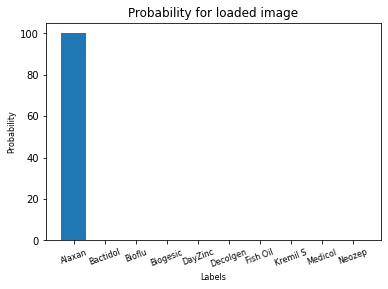

In [9]:
predict('Drug Vision/Data Combined/Alaxan/00000000.jpg')

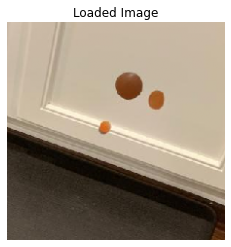

1/1 [==============================] - 0s 25ms/step


Maximum Probability:  1.0
Classified: Bactidol 



-------------------Individual Probability--------------------------------

ALAXAN : 0.0 %
BACTIDOL : 100.0 %
BIOFLU : 0.0 %
BIOGESIC : 0.0 %
DAYZINC : 0.0 %
DECOLGEN : 0.0 %
FISH OIL : 0.0 %
KREMIL S : 0.0 %
MEDICOL : 0.0 %
NEOZEP : 0.0 %


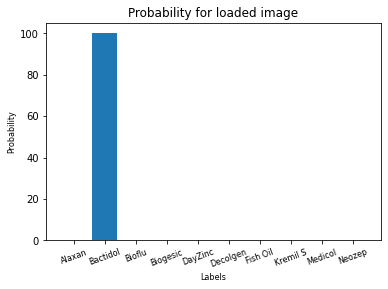

In [10]:
predict('Drug Vision/Data Combined/Bactidol/00000001.jpg')

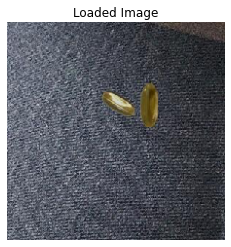

1/1 [==============================] - 0s 33ms/step


Maximum Probability:  1.0
Classified: Fish Oil 



-------------------Individual Probability--------------------------------

ALAXAN : 0.0 %
BACTIDOL : 0.0 %
BIOFLU : 0.0 %
BIOGESIC : 0.0 %
DAYZINC : 0.0 %
DECOLGEN : 0.0 %
FISH OIL : 100.0 %
KREMIL S : 0.0 %
MEDICOL : 0.0 %
NEOZEP : 0.0 %


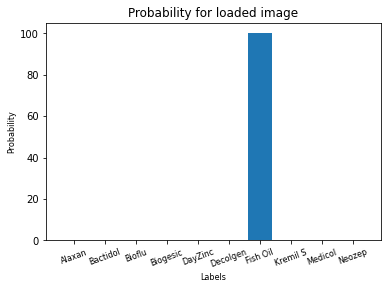

In [11]:
predict('Drug Vision/Data Combined/Fish Oil/00000001.jpg')

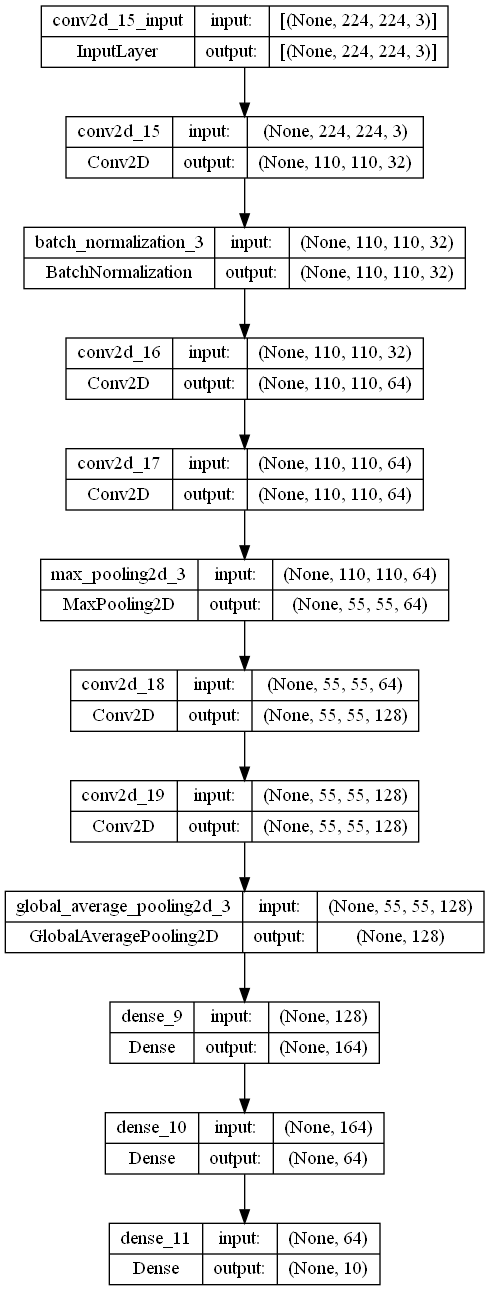

In [12]:
tf.keras.utils.plot_model(model2, show_shapes=True, show_layer_names=True, to_file='model.png')